In [2]:
import os
import random
import numpy as np
import tensorflow as tf

from easydict import EasyDict as edict
import matplotlib.pyplot as plt

# modules
from dataloader import Cifar10DataLoader, MnistDataLoader
from dnn import DNN
from unet import UNet

In [3]:
dataloader_args = edict({"batch_size": 256, "epochs": 50, "da": False})
# dataloader = MnistDataLoader(dataloader_args=dataloader_args)
dataloader = Cifar10DataLoader(dataloader_args=dataloader_args)
train_dataset, valid_dataset, test_dataset = dataloader.load_dataset()

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Predicted Image', 'Test Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def plot_train(display_list):
  # plt.figure(figsize=(10, 10))
  label = ['Train', 'Test']
  for i in range(len(display_list)):
    plt.plot(display_list[i], label=label[i])
  plt.legend()
  plt.show()
  

2023-01-31 16:28:55.005700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-31 16:28:55.006452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [4]:
model_args = edict({"units":[128,64,32,10], "activations":["relu","relu","relu","softmax"]})
model = DNN(units=model_args.units, activations=model_args.activations)

In [5]:
train_loss_fn = tf.keras.losses.CategoricalCrossentropy()
mt_loss_fn = tf.keras.metrics.Mean()
test_loss_fn = tf.keras.losses.CategoricalCrossentropy()
mte_loss_fn = tf.keras.metrics.Mean()
opt_loss_fn = tf.keras.losses.categorical_crossentropy

train_metrics = tf.keras.metrics.CategoricalAccuracy()
test_metrics = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(0.1)

In [6]:
# @tf.function(experimental_relax_shapes=True, experimental_compile=None)
def _train_step(inputs, labels, first_batch=False):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = train_loss_fn(labels, predictions)
        metrics = tf.reduce_mean(train_metrics(labels, predictions))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    mt_loss_fn.update_state(loss)
    
    return loss, metrics

def _test_step(inputs, labels):
    predictions = model(inputs)
    loss = test_loss_fn(labels, predictions)
    opt_loss = opt_loss_fn(labels, predictions)
    metrics = tf.reduce_mean(test_metrics(labels, predictions))
    mte_loss_fn.update_state(loss)
    
    return loss, metrics, opt_loss

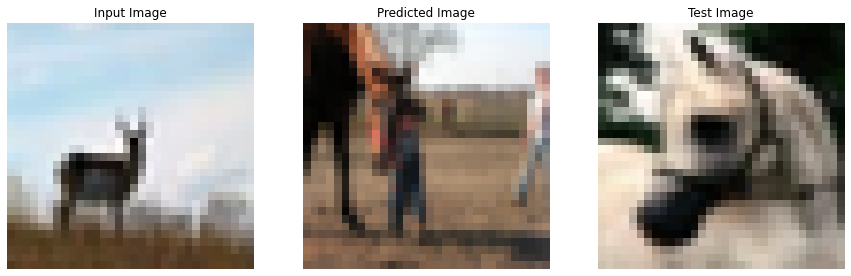

In [7]:
iter_train = iter(train_dataset)
iter_valid = iter(valid_dataset)
iter_test = iter(test_dataset)
test_data =  iter_test.get_next()

display([test_data["inputs"][0],test_data["inputs"][1],test_data["inputs"][2]])

In [8]:
model_opt = []
opt_label = []
def collect_model_operator(variables, loss):
    weights = [w.numpy() for w in variables]
    opt = DNN(units=model_args.units, 
            activations=model_args.activations,
            init_value=weights)
    opt_label.append(loss)
    model_opt.append(opt)

records = edict({'epoch':[],'train_loss':[],'test_loss':[],'train_metric':[],'test_metric':[]})
def obtain_model_opts(sample_start=30, sample_gap=20):
    for e in range(dataloader.info.epochs):
        mt_loss_fn.reset_states()
        train_metrics.reset_states()
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(dataloader.info.train_step):
            data = iter_train.get_next()
            train_loss, acc = _train_step(inputs=data["inputs"], labels=data["labels"])
            if (e*dataloader.info.train_step + step)%sample_gap ==0:
                if e >= sample_start:
                    test_loss, test_acc, opt_loss = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
                    collect_model_operator(model.trainable_variables, opt_loss)
                    
        test_loss, test_acc, _ = _test_step(inputs=test_data["inputs"], labels=test_data["labels"])
        records.epoch        += [e]
        records.train_loss   += [mt_loss_fn.result().numpy()]
        records.train_metric += [train_metrics.result().numpy()]
        records.test_loss    += [mte_loss_fn.result().numpy()]
        records.test_metric  += [test_metrics.result().numpy()]
        log = ""
        for k,v in records.items():
            log += "{}: {} ".format(k,v[-1])
        print(log)

In [9]:

def init_model_opt(raw_model_opt, data):
    
    def opt_test_step(opt, inputs, labels):
        predictions = opt(inputs)
        loss = test_loss_fn(labels, predictions)
        metrics = tf.reduce_mean(test_metrics(labels, predictions))
        mte_loss_fn.update_state(loss)
        return loss, metrics

    for idx in range(len(raw_model_opt)):
        mte_loss_fn.reset_states()
        test_metrics.reset_states()
        for step in range(1):
            data = test_data
            test_loss, test_acc = opt_test_step(opt=raw_model_opt[idx], inputs=data["inputs"], labels=data["labels"])
        print("Init: opt_id:{}, Test loss:{}, Test acc:{}".format(idx,
                                                        mte_loss_fn.result().numpy(),
                                                        test_metrics.result().numpy()))
            
def hard_save_model_opt(online_model_opt, path="./model_opt"):
    init_model_opt(online_model_opt, test_data)
    for idx in range(len(online_model_opt)):
        mpath = os.path.join(path, "opt_{}".format(idx))
        online_model_opt[idx].save(mpath, overwrite=True, save_format='tf')

def load_model_opt(path="./model_opt"):
    offline_model_opt = []
    model_opt_list = os.listdir(path=path)
    for idx in range(len(model_opt_list)):
        mpath = os.path.join(path,  "opt_{}".format(idx))
        offline_model_opt.append(tf.keras.models.load_model(mpath))
    init_model_opt(offline_model_opt, test_data)
    return offline_model_opt

In [11]:
GIAO_EPOCH = 1000
GIAO_BATCH = 4

giao_optimizer = tf.keras.optimizers.Adam(0.001)
giao_loss_fn = tf.keras.losses.MeanSquaredError()
def _opt_train_step(unet, regs, train_inputs, train_labels, labels):
    gradients = []
    losses = []
    for idx in range(len(regs)):
        with tf.GradientTape() as tape:
            pseudo_inputs = unet(train_inputs) + train_inputs
            # pseudo_inputs = train_inputs
            predictions = regs[idx](pseudo_inputs)
            reg_loss = opt_loss_fn(train_labels, predictions)
            # print(reg_loss, labels[idx])
            giao_loss = giao_loss_fn(labels[idx], reg_loss)
            losses.append(giao_loss)
            # print(giao_loss)
            grad = tape.gradient(giao_loss, unet.model.trainable_variables)
            if gradients == []:
                gradients = grad
            else:
                gradients = [sg1+sg2 for sg1,sg2 in zip(grad, gradients)]
        
    reduced_grads = [g/GIAO_BATCH for g in gradients]
    giao_optimizer.apply_gradients(zip(reduced_grads, unet.model.trainable_variables))
    reduced_loss = sum(losses)/GIAO_BATCH
    return reduced_loss, pseudo_inputs

Epoch:0 GIAO Train Loss:10.202844619750977


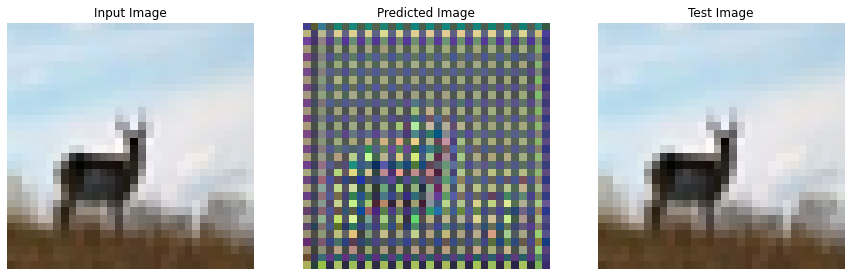

Epoch:100 GIAO Train Loss:0.6085959672927856


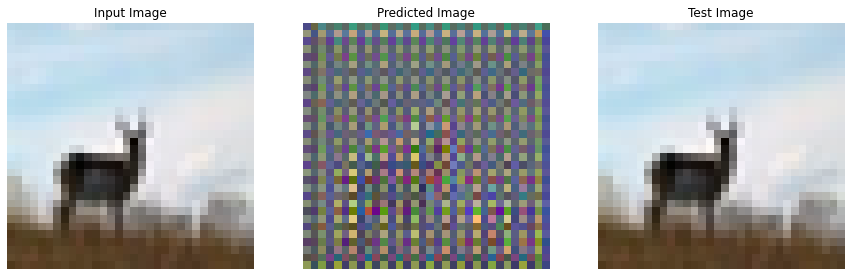

Epoch:200 GIAO Train Loss:0.22865934669971466


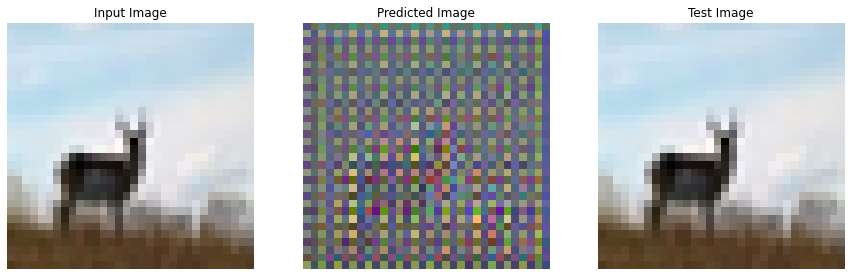

Epoch:300 GIAO Train Loss:0.18810947239398956


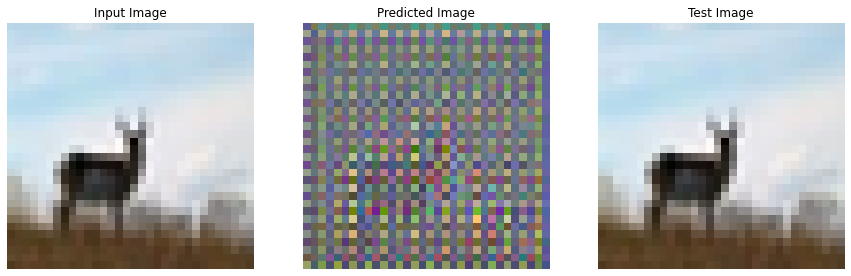

Epoch:400 GIAO Train Loss:0.15306192636489868


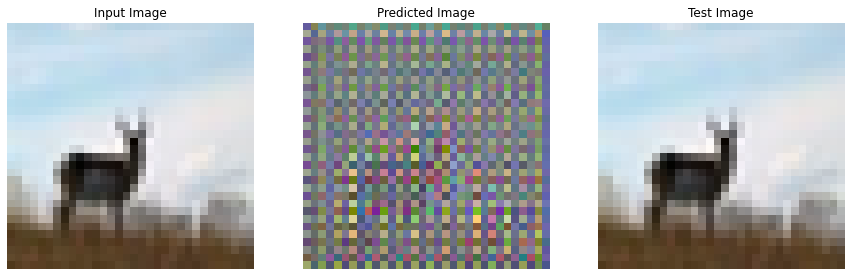

Epoch:500 GIAO Train Loss:0.1606418788433075


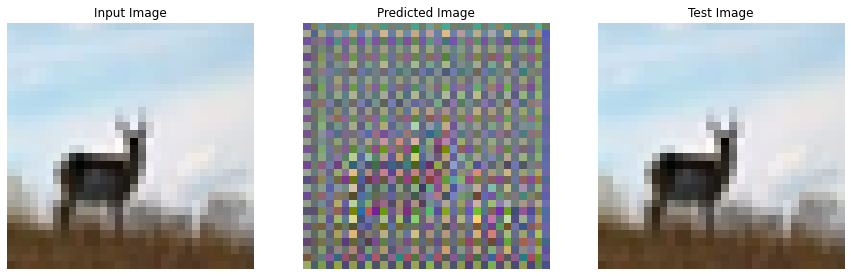

Epoch:600 GIAO Train Loss:0.13331039249897003


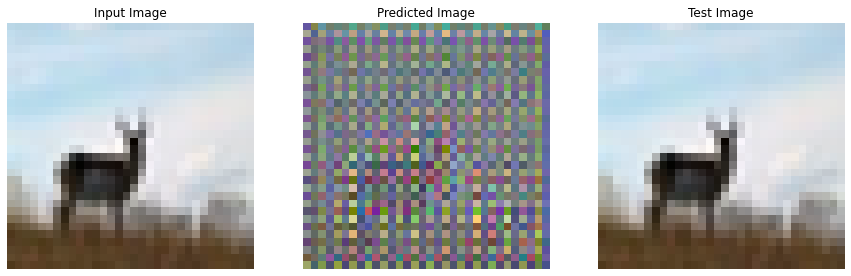

Epoch:700 GIAO Train Loss:0.10485000163316727


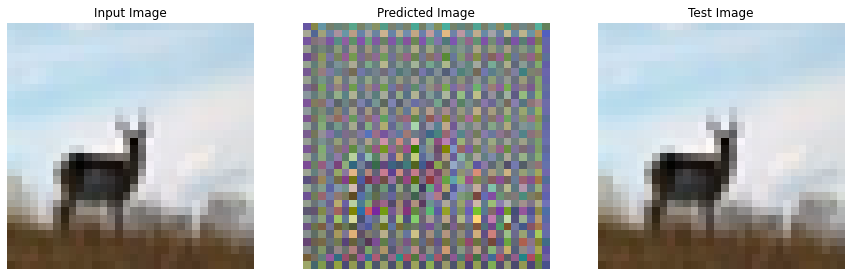

Epoch:800 GIAO Train Loss:0.1154346615076065


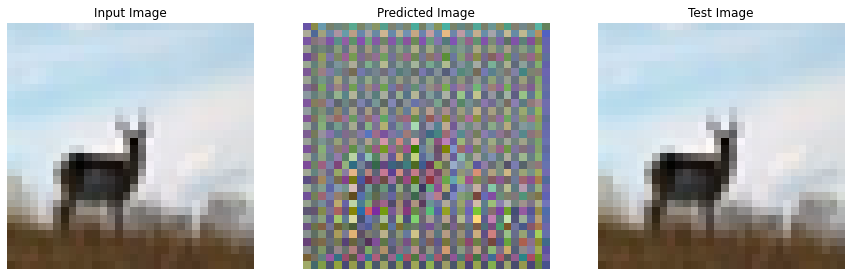

Epoch:900 GIAO Train Loss:0.1204042136669159


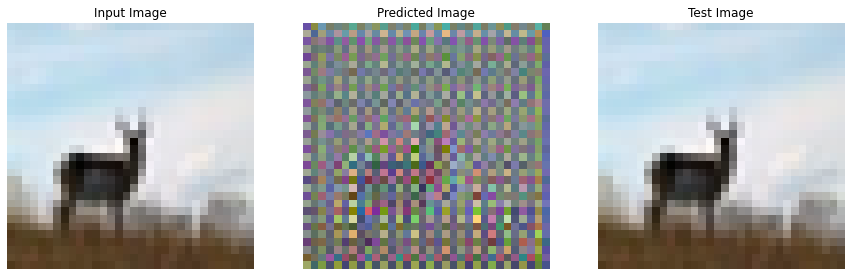

In [12]:

train_data = iter_train.get_next()

unet = UNet(input_shape=[32, 32, 3])

for i in range(GIAO_EPOCH):
    idx = random.sample(range(len(model_opt)), GIAO_BATCH)
    labels = [opt_label[i] for i in idx]
    regs = [model_opt[i] for i in idx]
    giao_train_loss, pseudo_inputs = _opt_train_step(unet, regs, test_data["inputs"], test_data["labels"], labels)
    if i % 100 == 0:
        print("Epoch:{} GIAO Train Loss:{}".format(i, giao_train_loss))
        display([test_data["inputs"].numpy()[0], pseudo_inputs.numpy()[0], test_data["inputs"][0]])
        

In [ ]:
# code test
for i in range(3):
    display([test_data["inputs"].numpy()[i], pseudo_inputs.numpy()[i], test_data["inputs"].numpy()[i]])


In [10]:
# training
obtain_model_opts(sample_start=30, sample_gap=20) 
print(len(model_opt))

epoch: 0 train_loss: 2.1412460803985596 test_loss: 1.972656488418579 train_metric: 0.20316506922245026 test_metric: 0.3203125 
epoch: 1 train_loss: 1.9359403848648071 test_loss: 1.808732032775879 train_metric: 0.2982872426509857 test_metric: 0.33203125 
epoch: 2 train_loss: 1.8437864780426025 test_loss: 1.7910629510879517 train_metric: 0.33837246894836426 test_metric: 0.33203125 
epoch: 3 train_loss: 1.7818089723587036 test_loss: 1.6765079498291016 train_metric: 0.3599027097225189 test_metric: 0.37890625 
epoch: 4 train_loss: 1.7343543767929077 test_loss: 1.6109312772750854 train_metric: 0.3779350221157074 test_metric: 0.41015625 
epoch: 5 train_loss: 1.6888110637664795 test_loss: 1.5702049732208252 train_metric: 0.3935147821903229 test_metric: 0.41015625 
epoch: 6 train_loss: 1.656002163887024 test_loss: 1.6433517932891846 train_metric: 0.40821003913879395 test_metric: 0.38671875 
epoch: 7 train_loss: 1.624817132949829 test_loss: 1.6246354579925537 train_metric: 0.41918623447418213 te

In [ ]:
# save model opt
hard_save_model_opt(model_opt)

In [ ]:
# load model opt
model_opt = load_model_opt()

In [ ]:
# metrics visualization
plot_train([records.train_loss, records.test_loss])
plot_train([opt_label, opt_label])

In [ ]:
train_data = iter_train.get_next()

unet = UNet(input_shape=[32, 32, 3])
output = unet(train_data["inputs"])
print(output.shape)
display([train_data["inputs"].numpy()[0],output.numpy()[0]])